In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau





c:\VIT-AP\NIDS Project\ids_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Load Dataset
df = pd.read_csv('NF-UNSW-NB15-v3.csv', nrows=100000)


# Remove Infinity Values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)




# Display basic info
print("Dataset Shape:", df.shape)
print("Missing Values:", df.isnull().sum().sum())
print("Unique Attack Types:", df['Attack'].unique())

Dataset Shape: (92577, 55)
Missing Values: 0
Unique Attack Types: ['Benign' 'Fuzzers' 'Exploits' 'Backdoor' 'Generic' 'DoS' 'Reconnaissance'
 'Shellcode' 'Analysis' 'Worms']


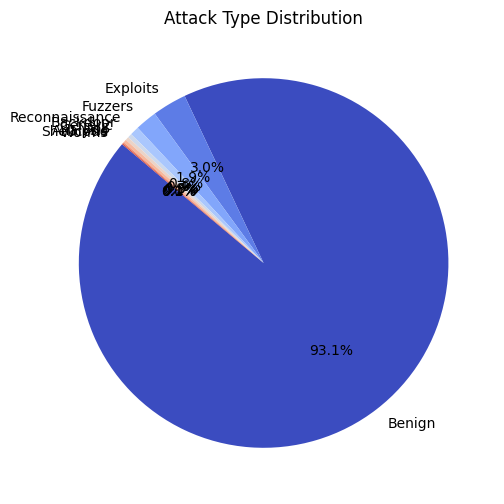

In [4]:
# Pie Chart for Attack Distribution
plt.figure(figsize=(8, 6))
df['Attack'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='coolwarm')
plt.title("Attack Type Distribution")
plt.ylabel('')
plt.show()


C:\Users\Hp\AppData\Local\Temp\ipykernel_10100\3047130023.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='coolwarm')


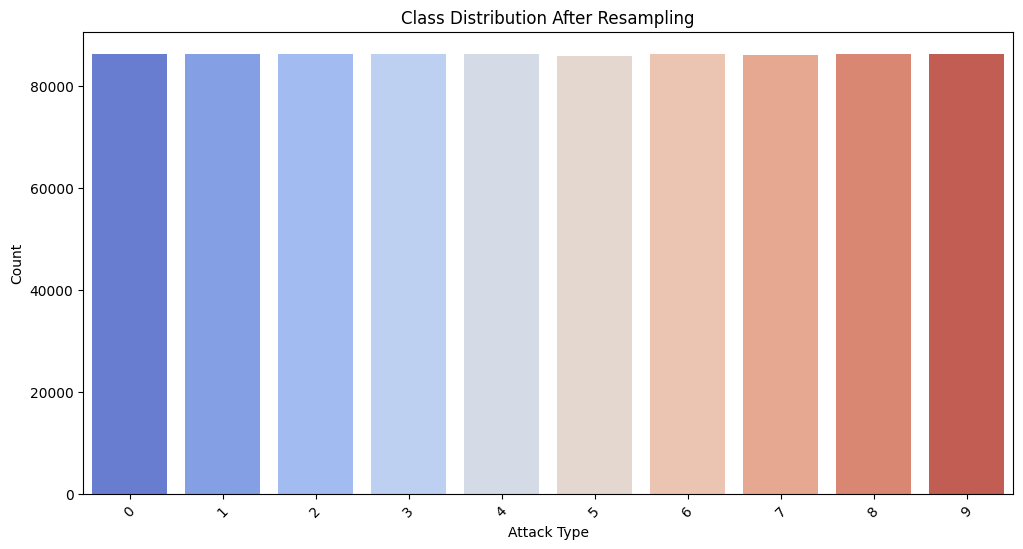

In [5]:
from imblearn.over_sampling import ADASYN

# Encode categorical labels
encoder = LabelEncoder()
df['Attack'] = encoder.fit_transform(df['Attack'])

# Drop unnecessary columns
features_to_remove = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'FTP_COMMAND_RET_CODE']
df.drop(columns=features_to_remove, inplace=True, errors='ignore')


# Feature selection using SHAP
X = df.drop(columns=['Attack', 'Label'])

y = df['Attack']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=1)

# Apply ADASYN to balance classes
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Ensure 'Label' is not included in the feature
# Normalize features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Reshape input for Transformer
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)


# Plot class distribution after SMOTE
plt.figure(figsize=(12, 6))
sns.countplot(x=y_resampled, palette='coolwarm')
plt.title("Class Distribution After Resampling")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.show()


In [6]:
# Define Enhanced Transformer Model
def transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=8, key_dim=64)(inputs, inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    residual = Add()([inputs, x])
    x = MultiHeadAttention(num_heads=8, key_dim=64)(residual, residual)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)


# Initialize Model
num_classes = len(np.unique(y_resampled))
model = transformer_model((1, X_train.shape[2]), num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping & Learning Rate Scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, verbose=1, callbacks=[early_stopping, lr_scheduler], class_weight=class_weight_dict)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/30
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 215s 19ms/step - accuracy: 0.6698 - loss: 1.2088 - val_accuracy: 0.7834 - val_loss: 0.7098 - learning_rate: 0.0010
Epoch 2/30
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 210s 19ms/step - accuracy: 0.7518 - loss: 0.8047 - val_accuracy: 0.8017 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 3/30
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 247s 23ms/step - accuracy: 0.7660 - loss: 0.7584 - val_accuracy: 0.8014 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 4/30
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 1229s 114ms/step - accuracy: 0.7737 - loss: 0.7372 - val_accuracy: 0.8125 - val_loss: 0.6132 - learning_rate: 0.0010
Epoch 5/30
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 2424s 225ms/step - accuracy: 0.7804 - loss: 0.7195 - val_accuracy: 0.8266 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 6/30
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 1796s 167ms/step - accuracy: 0.7829 - loss: 0.7126 - val_accuracy: 0.8329 - val_loss: 0.5767 - learning_rate: 0.0010
Epoch 7/30
10772/10772 ━━━━━━━━━━━━━━━━━

5386/5386 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     17246
           1       0.94      0.96      0.95     17253
           2       1.00      1.00      1.00     17246
           3       0.69      0.82      0.75     17227
           4       0.92      0.45      0.60     17258
           5       0.79      0.89      0.84     17150
           6       0.87      0.88      0.88     17264
           7       0.88      0.79      0.84     17208
           8       0.92      1.00      0.96     17241
           9       1.00      1.00      1.00     17246

    accuracy                           0.88    172339
   macro avg       0.88      0.88      0.87    172339
weighted avg       0.88      0.88      0.87    172339

Matthews Correlation Coefficient: 0.8661611169062977


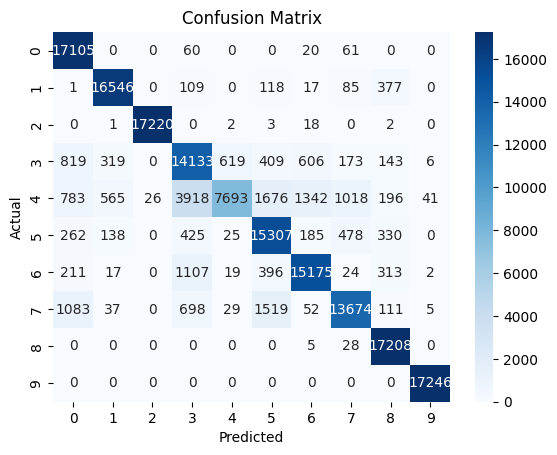

ROC-AUC Score: 0.9869


In [7]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Performance Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")


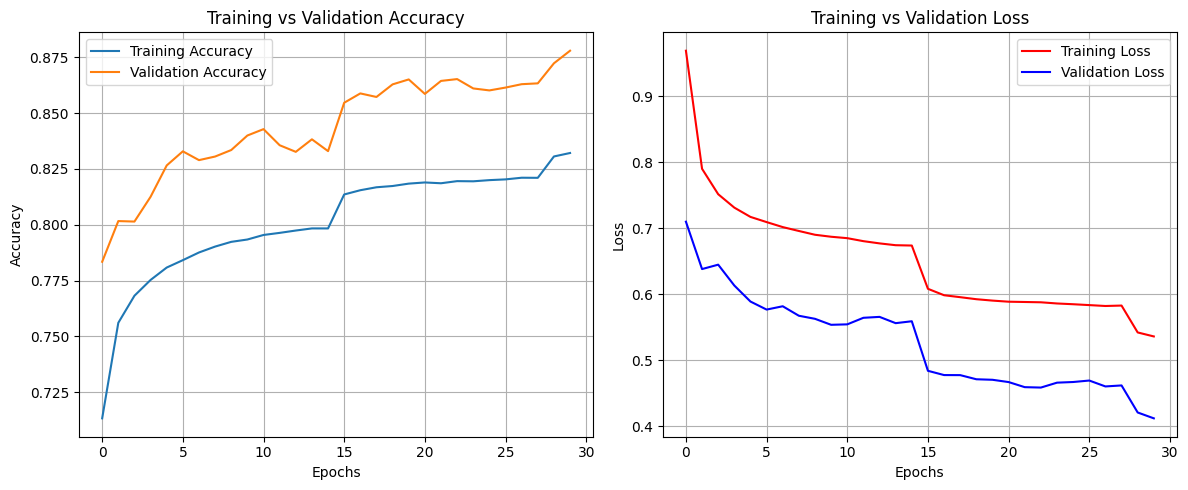

In [8]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 📈 Plot Training & Validation Accuracy
ax[0].plot(train_acc, label='Training Accuracy' )
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].set_title('Training vs Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

# 📉 Plot Training & Validation Loss
ax[1].plot(train_loss, label='Training Loss',  color='red')
ax[1].plot(val_loss, label='Validation Loss',color='blue')
ax[1].set_title('Training vs Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()


In [18]:
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Ensure scaler is fitted
scaler = StandardScaler()
scaler.fit(X_resampled)  # X_resampled should be your processed training data
joblib.dump(scaler, "scaler.pkl")

# Ensure label encoder is fitted
encoder = LabelEncoder()
encoder.fit(y_resampled)  # y_resampled should be your label data
joblib.dump(encoder, "label_encoder.pkl")

# Save the Keras model
model.save("nids_transformer.keras")  # Preferred format

print("Model, Scaler, and Label Encoder saved successfully!")


Model, Scaler, and Label Encoder saved successfully!


In [19]:
from tensorflow.keras.models import load_model
# Test sample with initial values (49 features including the ones to remove)
test_sample = np.array([
    12345,              # L4_SRC_PORT (Source port number)
    80,                 # L4_DST_PORT (Destination port number)
    6,                  # PROTOCOL (TCP)
    1,                  # L7_PROTO (Layer 7 Protocol: HTTP)
    5000,               # IN_BYTES (Incoming bytes)
    2000,               # OUT_BYTES (Outgoing bytes)
    50,                 # IN_PKTS (Incoming packets)
    20,                 # OUT_PKTS (Outgoing packets)
    150,                # FLOW_DURATION_MILLISECONDS (Flow duration in ms)
    2,                  # TCP_FLAGS (Flags like SYN, ACK)
    1,                  # CLIENT_TCP_FLAGS (Client side TCP flags)
    1,                  # SERVER_TCP_FLAGS (Server side TCP flags)
    100,                # DURATION_IN (Client to server stream duration)
    120,                # DURATION_OUT (Server to client stream duration)
    5,                  # MIN_TTL (Minimum flow TTL)
    64,                 # MAX_TTL (Maximum flow TTL)
    1200,               # LONGEST_FLOW_PKT (Longest packet length)
    50,                 # SHORTEST_FLOW_PKT (Shortest packet length)
    40,                 # MIN_IP_PKT_LEN (Smallest IP packet length)
    1500,               # MAX_IP_PKT_LEN (Largest IP packet length)
    10,                 # SRC_TO_DST_SECOND_BYTES (Source to destination bytes/sec)
    15,                 # DST_TO_SRC_SECOND_BYTES (Destination to source bytes/sec)
    300,                # RETRANSMITTED_IN_BYTES (Retransmitted bytes src -> dst)
    5,                  # RETRANSMITTED_IN_PKTS (Retransmitted packets src -> dst)
    350,                # RETRANSMITTED_OUT_BYTES (Retransmitted bytes dst -> src)
    4,                  # RETRANSMITTED_OUT_PKTS (Retransmitted packets dst -> src)
    8,                  # SRC_TO_DST_AVG_THROUGHPUT (Source to destination avg throughput)
    7,                  # DST_TO_SRC_AVG_THROUGHPUT (Destination to source avg throughput)
    2,                  # NUM_PKTS_UP_TO_128_BYTES (Packets of size <= 128 bytes)
    3,                  # NUM_PKTS_128_TO_256_BYTES (Packets size > 128 <= 256 bytes)
    4,                  # NUM_PKTS_256_TO_512_BYTES (Packets size > 256 <= 512 bytes)
    5,                  # NUM_PKTS_512_TO_1024_BYTES (Packets size > 512 <= 1024 bytes)
    2,                  # NUM_PKTS_1024_TO_1514_BYTES (Packets size > 1024 <= 1514 bytes)
    1000,               # TCP_WIN_MAX_IN (Maximum TCP window size in bytes src -> dst)
    1000,               # TCP_WIN_MAX_OUT (Maximum TCP window size dst -> src)
    10,                 # ICMP_TYPE (ICMP type code)
    20,                 # ICMP_IPV4_TYPE (ICMP IPv4 type)
    60,                 # DNS_TTL_ANSWER (DNS TTL of the first answer)
        
    1645737625000,      # FLOW_START_MILLISECONDS (Flow start timestamp in ms)
    1645737685000,      # FLOW_END_MILLISECONDS (Flow end timestamp in ms)
    0.1,                # SRC_TO_DST_IAT_MIN (Min Inter-Packet Arrival Time src -> dst)
    0.5,                # SRC_TO_DST_IAT_MAX (Max Inter-Packet Arrival Time src -> dst)
    0.3,                # SRC_TO_DST_IAT_AVG (Average Inter-Packet Arrival Time src -> dst)
    0.15,               # SRC_TO_DST_IAT_STDDEV (Standard deviation of Inter-Packet Arrival Time src -> dst)
    0.05,               # DST_TO_SRC_IAT_MIN (Min Inter-Packet Arrival Time dst -> src)
    0.25,               # DST_TO_SRC_IAT_MAX (Max Inter-Packet Arrival Time dst -> src)
    0.15,               # DST_TO_SRC_IAT_AVG (Average Inter-Packet Arrival Time dst -> src)
    0.1                 # DST_TO_SRC_IAT_STDDEV (Standard deviation of Inter-Packet Arrival Time dst -> src)
])


# Create a list of features
all_features = [
     'L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 
    'IN_PKTS', 'OUT_PKTS', 'FLOW_DURATION_MILLISECONDS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 
    'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 
    'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 
    'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 
    'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 
    'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 
    'ICMP_IPV4_TYPE',  'DNS_TTL_ANSWER',  'FLOW_START_MILLISECONDS', 
    'FLOW_END_MILLISECONDS', 'SRC_TO_DST_IAT_MIN', 'SRC_TO_DST_IAT_MAX', 'SRC_TO_DST_IAT_AVG', 'SRC_TO_DST_IAT_STDDEV', 
    'DST_TO_SRC_IAT_MIN', 'DST_TO_SRC_IAT_MAX', 'DST_TO_SRC_IAT_AVG', 'DST_TO_SRC_IAT_STDDEV'
]



# Reshape the test sample to match the expected shape (1, n_features)
test_sample = test_sample.reshape(1, -1)

# Load the scaler (standardization used during training)
scaler = joblib.load("scaler.pkl")

# Normalize the test sample using the same scaler as in training
test_sample = scaler.transform(test_sample)

# If the model requires reshaping for time-series data or sequence models (e.g., LSTM)
test_sample= np.expand_dims(test_sample, axis=1)

# Load the trained model (assumed to be saved earlier)
model = load_model("nids_transformer.keras")

# Make prediction
prediction = model.predict(test_sample)

# Decode the predicted label
encoder = joblib.load("label_encoder.pkl")
predicted_label = encoder.inverse_transform([np.argmax(prediction)])

# Print the predicted attack type
print(f"Predicted Attack Type: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicted Attack Type: 5
